# SINVAD Experiments - Research Question 4 (VAE Architecture)

This notebook provides outlines on experiments performed for RQ4 (Section 5.5 of the paper). It contains code that generates results similar to those presented in Figure 16-17 of the paper.

## Step 0. Preparation

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
plt.style.use('seaborn')

from vae.model import VAE, ConvVAE
from sa.model import MnistClassifier

In [2]:
# Hyper-parameters
img_size = 1*28*28
h_dim = 1600
batch_size = 128
device = 'cuda'
dataset_name = 'FMNIST'

In [3]:
# MNIST dataset
if dataset_name == 'MNIST':
    dataset = torchvision.datasets.MNIST(root='./data',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=True)
else:
    dataset = torchvision.datasets.FashionMNIST(root='./data',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [4]:
classifier = MnistClassifier(img_size=img_size)
classifier.load_state_dict(torch.load(f'./sa/models/{dataset_name}_conv_classifier.pth'))
classifier.to(device)
classifier.eval()

MnistClassifier(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=3136, out_features=512, bias=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=512, out_features=10, 

## Step 1. Qualitiative Comparison of VAEs (Figure 16)

tensor([[ -4.9921,  -8.7383,   4.1295,  -9.4936,   5.0280, -12.2037,  -2.6273,
         -18.0860,  -7.9757, -11.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)


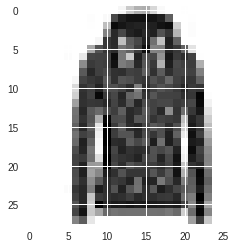

In [5]:
for i, (x, true_label) in enumerate(data_loader):
    my_image = x[0:1]
    print(classifier(my_image.to(device)))
    break

# print(my_image.size())
plt.imshow((255*my_image[0].numpy().transpose((1, 2, 0))[:, :, 0]).astype(np.uint8))

In [6]:
AVAIL_Z_DIMS = [1, 4, 10, 40, 100, 400, 1000, 2000]

In [7]:
reconst_imgs = []
conv_reconst_imgs = []
for z_dim in AVAIL_Z_DIMS:
    with torch.no_grad():
        model = VAE(img_size = img_size, h_dim = h_dim, z_dim = z_dim)
        model.load_state_dict(torch.load(f'vae/models/{dataset_name}_EnD_h{h_dim}_z{z_dim}.pth'))
        model.to(device)

        vae_input = my_image.to(device).view(-1, img_size)
        x_reconst, mu, log_var = model(vae_input)
        reconst_imgs.append(x_reconst.cpu().numpy())
        
        model = ConvVAE(img_size = (28, 28), c_num = 1, h_dim = h_dim, z_dim = z_dim)
        model.load_state_dict(torch.load(f'vae/models/{dataset_name}_ConvEnD_h{h_dim}_z{z_dim}.pth'))
        model.to(device)
        
        x_reconst, mu, log_var = model(my_image.to(device))
        conv_reconst_imgs.append(x_reconst.cpu().numpy())
        

/home/sungmin/Documents/dlTestGen/dlenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


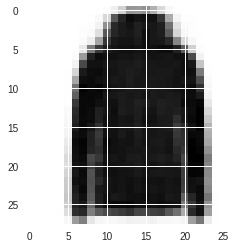

In [8]:
plt.imshow(conv_reconst_imgs[1].reshape((28, 28)))

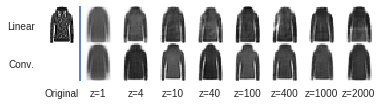

In [9]:
showcase = np.zeros((28*2, 28*9))
showcase[0:28, 0:28] = my_image[0, 0].numpy()

for idx in range(1, 8+1):
    showcase[0:28, 28*idx:28*(idx+1)] = reconst_imgs[idx-1].reshape((28, 28))
    showcase[28:2*28, 28*idx:28*(idx+1)] = conv_reconst_imgs[idx-1].reshape((28, 28))

plt.imshow(showcase)
plt.axvline(28)
plt.xticks(range(14, 28*9+14, 28), ['Original'] + ['z='+str(e) for e in AVAIL_Z_DIMS])
plt.yticks([14, 42], ['Linear', 'Conv.'])
plt.grid(False)

## Quantitative Evaluation of VAE Architectures (Figure 17)

In [10]:
with torch.no_grad():
    vae_reconst_scores = []
    conv_vae_reconst_scores = []
    for z_dim in AVAIL_Z_DIMS:
        vae = VAE(img_size = img_size, h_dim = h_dim, z_dim = z_dim)
        vae.load_state_dict(torch.load(f'vae/models/{dataset_name}_EnD_h{h_dim}_z{z_dim}.pth'))
        vae.to(device)
        vae_scores = 0
        conv_vae = ConvVAE(img_size = (28, 28), c_num = 1, h_dim = h_dim, z_dim = z_dim)
        conv_vae.load_state_dict(torch.load(f'vae/models/{dataset_name}_ConvEnD_h{h_dim}_z{z_dim}.pth'))
        conv_vae.to(device)
        conv_vae_scores = 0
        actual_acc = 0
        # ----
        for i, (x, true_label) in enumerate(data_loader):
            true_label = true_label.to(device)
            _, pred_labels = torch.max(classifier(x.to(device)), axis=1)
            actual_acc += (true_label == pred_labels).sum().item()
            vae_input = x.to(device).view(-1, img_size)
            vae_reconst_imgs, _, _ = vae(vae_input)
            vae_reconst_imgs = vae_reconst_imgs.view(-1, 1, 28, 28)
            conv_vae_reconst_imgs, _, _ = conv_vae(x.to(device))
            
            _, vae_reconst_preds = torch.max(classifier(vae_reconst_imgs), axis=1)
            _, conv_vae_reconst_preds = torch.max(classifier(conv_vae_reconst_imgs), axis=1)
            vae_reconst_acc = (true_label == vae_reconst_preds).sum().item()
            conv_vae_reconst_acc = (true_label == conv_vae_reconst_preds).sum().item()
            vae_scores += vae_reconst_acc
            conv_vae_scores += conv_vae_reconst_acc
        vae_reconst_scores.append(vae_scores)
        conv_vae_reconst_scores.append(conv_vae_scores)

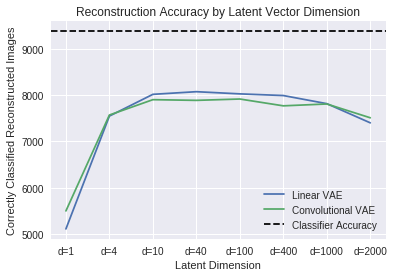

In [11]:
plt.plot(vae_reconst_scores, label='Linear VAE')
plt.plot(conv_vae_reconst_scores, label='Convolutional VAE')
plt.axhline(actual_acc, ls='--', color='black', label='Classifier Accuracy')
plt.legend()
plt.title('Reconstruction Accuracy by Latent Vector Dimension')
plt.xticks(range(0, 8), ['d='+str(e) for e in AVAIL_Z_DIMS])
plt.xlabel('Latent Dimension')
plt.ylabel('Correctly Classified Reconstructed Images')